# Time Series Model for Cryptocurrency Price Forecasting

The goal of this notebook is to attempt to develop a time series model using SARIMAX (from the statstools library) to forecast future prices of Bitcoin.

In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import numpy as np
import sklearn 
import seaborn as sns

%matplotlib inline
sns.set()

The price information for Bitcoin is obtained through Binance.com, an exchange for cryptocurrencies. Access to the API is free with a free account (you must register). 

For security purposes, I previously accessed the price information with my personal credentials, and stored the prices as a CSV, available in this Git repository. The code for accessing the Binance information is included below for reference purposes.

In [19]:
'''
from binance.client import Client

key = "" #Input personal Binance Key as string.
code = "" #Input personal Binance Security Code as string.

client = Client(key,code)

symbol = 'BTCUSDT'
BTC = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY,  "1 Dec, 2016")
df_BTC = pd.DataFrame(BTC, columns= ['Open_Time','Open','High','Low','Close','Volume','Close_Time','Quote_Asset_Volume','Num_Trades','Taker_Buy_Base_Asset volume','Taker_Buy_Quote_Asset_Volume','IGNORE'])
df_BTC.to_csv('df_BTC.csv',index=False)
'''

In [38]:
df_BTC = pd.read_csv('df_BTC.csv')

In [39]:
df_BTC.head()

,Open_Time,Open,High,Low,Close,Volume,Close_Time,Quote_Asset_Volume,Num_Trades,Taker_Buy_Base_Asset volume,Taker_Buy_Quote_Asset_Volume,IGNORE
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,1503014399999,3.454770e+06,3427,616.248541,2.678216e+06,8733.911395
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,1503100799999,5.086958e+06,5233,972.868710,4.129123e+06,9384.141409
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,1503187199999,1.549484e+06,2153,274.336042,1.118002e+06,9184.085529
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,1503273599999,1.930364e+06,2321,376.795947,1.557401e+06,10125.414084
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,1503359999999,2.797232e+06,3972,557.356107,2.255663e+06,11706.769970


In [40]:
df_BTC.dtypes

Open_Time                         int64
Open                            float64
High                            float64
Low                             float64
Close                           float64
Volume                          float64
Close_Time                        int64
Quote_Asset_Volume              float64
Num_Trades                        int64
Taker_Buy_Base_Asset volume     float64
Taker_Buy_Quote_Asset_Volume    float64
IGNORE                          float64
dtype: object

In [79]:
#To prepare Convert "Open Time" to Date Time and convert this column into our index. To perform Time Series, 
#our index will consist of DateTime values. The existing time elements are in units of milliseconds (ms)

df_BTC['Open_Time'] = pd.to_datetime(df_BTC['Open_Time'], unit='ms')
df_BTC.index = pd.DatetimeIndex(df_BTC['Open_Time'], freq='D')
df_BTC.drop(['Open_Time'], axis=1, inplace=True)

In [50]:
#Note - if we used the dataframe straight from Binance and not from a CSV file, we would need to convert
#the "object" data types to floats. This automatically happens with the CSV conversion. This code can be used if 
#the crypto data is used directly from Binance.


'''
for col in df_BTC.columns:
    if df_BTC[col].dtypes ==object:
        df_BTC[col] = df_BTC[col].astype(float)
'''

'\nfor col in df_BTC.columns:\n    if df_BTC[col].dtypes ==object:\n        df_BTC[col] = df_BTC[col].astype(float)\n'

In [80]:
df_BTC = df_BTC.round(2)

In [42]:
# Now lets extract the NASDAQ index daily value for this period from Quandl. An account is required with quandl.com
# to obtain access to the API. For security purposes, I imported the information with the code below and imported
# it to a CSV (similar to above). We will then import the CSV and use this for this example.

'''
import datetime, quandl
quandl.ApiConfig.api_key = "" #INSERT PERSONAL API KEY (not including mine here, sorry)

ndq = pd.DataFrame(quandl.get("NASDAQOMX/COMP-NASDAQ", 
              trim_start='2017-09-30', 
              trim_end='2019-07-10'))
              
ndq.reset_index(inplace=True)
ndq.to_csv('df_NDQ.csv',index=False)
'''

In [73]:
df_NDQ = pd.read_csv('df_NDQ.csv')
df_NDQ.head(3)

,Trade Date,Index Value,High,Low,Total Market Value,Dividend Market Value
0,2017-10-02,6516.72,6527.22,6484.14,9.768455e+12,1.584905e+07
1,2017-10-03,6531.71,6532.18,6509.71,9.791903e+12,7.568901e+08
2,2017-10-04,6534.63,6546.46,6513.12,9.790145e+12,1.502742e+09


In [74]:
df_NDQ.tail(1)  #Final row

,Trade Date,Index Value,High,Low,Total Market Value,Dividend Market Value
444,2019-07-10,8202.53,8228.6,8160.56,1.227944e+13,13312659.0


In [75]:
# Similar to the Bitcoin dataframe, we need to convert the Trade Date to DateTime and make it our index.

df_NDQ['Trade Date'] = pd.to_datetime(df_NDQ['Trade Date'])
df_NDQ.index = pd.DatetimeIndex(df_NDQ['Trade Date'])
df_NDQ.drop(['Trade Date'], axis=1, inplace=True)
df_NDQ.head(7)

,Index Value,High,Low,Total Market Value,Dividend Market Value
Trade Date,,,,,
2017-10-02,6516.72,6527.22,6484.14,9.768455e+12,1.584905e+07
2017-10-03,6531.71,6532.18,6509.71,9.791903e+12,7.568901e+08
2017-10-04,6534.63,6546.46,6513.12,9.790145e+12,1.502742e+09
2017-10-05,6585.36,6587.21,6547.65,9.866199e+12,1.260852e+08
2017-10-06,6590.18,6590.18,6566.84,9.874186e+12,1.411987e+08
2017-10-09,6579.73,6599.34,6572.44,9.855755e+12,0.000000e+00
2017-10-10,6587.25,6608.30,6561.78,9.870433e+12,1.580630e+07


In [100]:
# Merge information from Bitcoin and NASDAQ index into new data frame

df_m=pd.merge(df_BTC['Close'],df_NDQ['Index Value'], how='outer', left_index=True, right_index=True)
df_m.rename(columns={'Close':'Bitcoin','Index Value':'Nasdaq'}, inplace=True)


In [101]:
df_m = df_m.loc['2017-10-02':'2019-07-10']
df_m.head(7)

,Bitcoin,Nasdaq
2017-10-02,4380.00,6516.72
2017-10-03,4310.00,6531.71
2017-10-04,4208.59,6534.63
2017-10-05,4292.43,6585.36
2017-10-06,4369.00,6590.18
2017-10-07,4423.00,NaN
2017-10-08,4640.00,NaN


In [102]:
# Note that the Nasdaq values are 'NaN' for weekend dates. For simplicity, lets copy the preceding Friday value
# to stand in for the weekends. We could linearly interpolate between Friday and Monday as well.

df_m.fillna(method='ffill', inplace=True)
df_m.head(7)

,Bitcoin,Nasdaq
2017-10-02,4380.00,6516.72
2017-10-03,4310.00,6531.71
2017-10-04,4208.59,6534.63
2017-10-05,4292.43,6585.36
2017-10-06,4369.00,6590.18
2017-10-07,4423.00,6590.18
2017-10-08,4640.00,6590.18


# Visualize

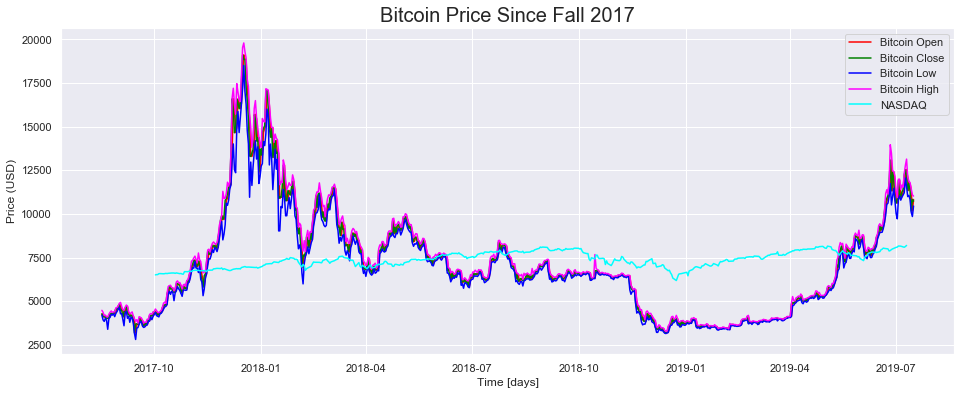

In [108]:
#View Bitcoin price over time since Fall 2017.

plt.figure(figsize=(16, 6));
plt.plot(df_BTC.Open, color='red', label='Bitcoin Open')
plt.plot(df_BTC.Close, color='green', label='Bitcoin Close')
plt.plot(df_BTC.Low, color='blue', label='Bitcoin Low')
plt.plot(df_BTC.High, color='magenta', label='Bitcoin High')
plt.plot(ndq['Index Value'], color='cyan', label='NASDAQ')
plt.title('Bitcoin Price Since Fall 2017', fontsize=20)
plt.xlabel('Time [days]')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.show()

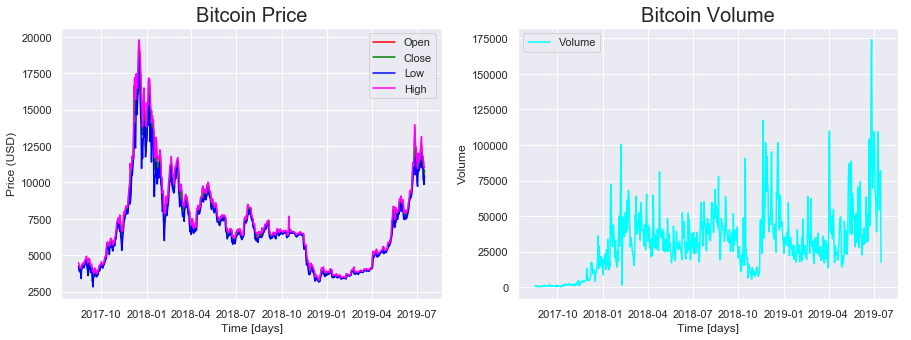

In [106]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df_BTC.Open, color='red', label='Open')
plt.plot(df_BTC.Close, color='green', label='Close')
plt.plot(df_BTC.Low, color='blue', label='Low')
plt.plot(df_BTC.High, color='magenta', label='High')
plt.title('Bitcoin Price', fontsize=20)
plt.xlabel('Time [days]')
plt.ylabel('Price (USD)')
plt.legend(loc='best')


plt.subplot(1,2,2);
plt.plot(df_BTC.Volume, color='cyan', label='Volume')
plt.title('Bitcoin Volume', fontsize=20)
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.show()

#### Review decomposed parameters of the Bitcoin Closing Prices over time

In [109]:
import statsmodels.api as sms

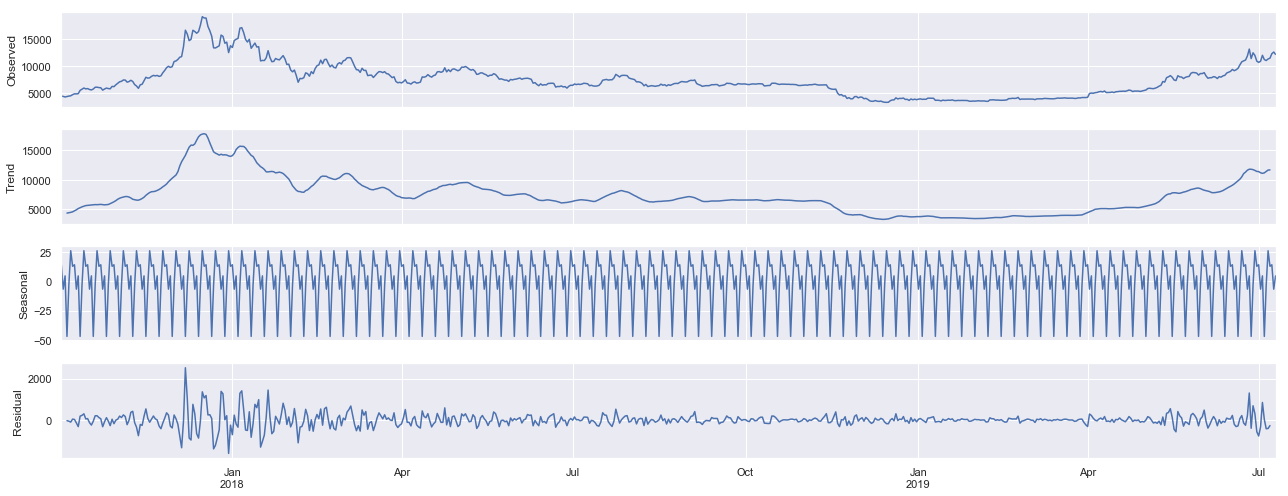

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7
decomp  = sms.tsa.seasonal_decompose(df_m['Bitcoin'], model='additive')

fig = decomp.plot()
plt.show()

# Check for Stationarity

From the figures above, we can observe that we have some seasonality (7 day periods), and a trend that is not obvious. Before we can apply a SARIMAX model, we need to confirm that our data is stationary (that our mean, standard deviation over time is fairly constant). If it isn't, we'll need to massage the data to "make it" stationary.

In [111]:
rol_mean = df_m['Bitcoin'].rolling(window=7).mean()
rol_std = df_m['Bitcoin'].rolling(window=7).std()

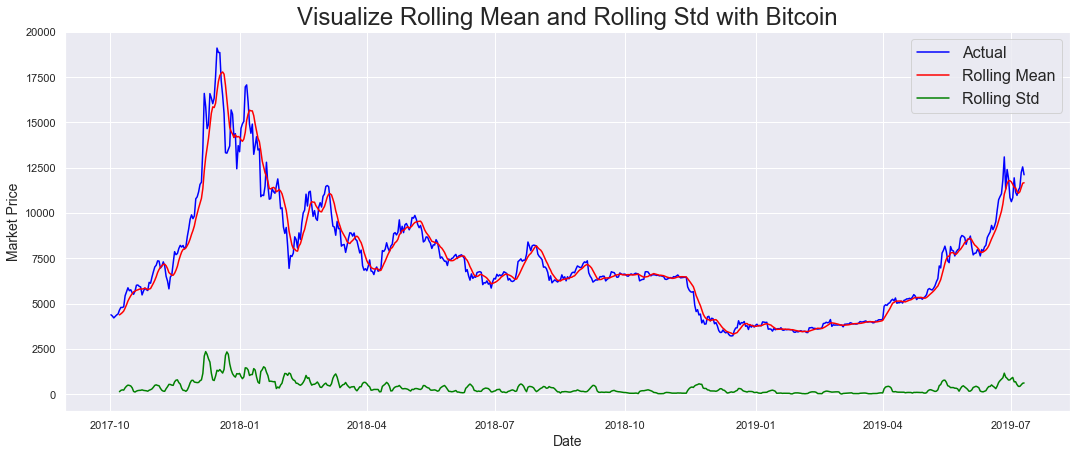

In [112]:
# Plot rolling statistics, to visualize our mean and standard deviation over time.

plt.figure(figsize=(18,7))
orig = plt.plot(df_m['Bitcoin'], color='blue',label='Actual')
mean = plt.plot(rol_mean, color='red',label='Rolling Mean')
std = plt.plot(rol_std, color='green',label='Rolling Std')
plt.legend(loc='best', fontsize=16)
plt.title("Visualize Rolling Mean and Rolling Std with Bitcoin", fontsize=24)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Market Price', fontsize=14)
plt.show(block=False)


Our data certainly does not look stationary. To confirm, lets run a Dickey Fuller Test to check for stationarity numerically.

In [114]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(df_m['Bitcoin'],autolag='AIC')
print("Dickey-Fuller Test Results")
print("")
print(f"ADF STATS: {res[0]}")
print(f"p-value: {res[1]}")
print(f"Lags Used: {res[2]}")
print("")

print('Critical Values:')

for i,j in res[4].items():
    print(f"\t {i}: {j}")

Dickey-Fuller Test Results

ADF STATS: -2.0152693658752274
p-value: 0.27991840596871725
Lags Used: 20

Critical Values:
	 1%: -3.4408393249134326
	 5%: -2.86616806030903
	 10%: -2.569234676071002


#### Since our p-value exceeds 0.05, we cannot reject the null hypothesis Ho. Therefore, our data as it stands is non-stationary. Lets try differencing the data by 1 step to see if our data becomes stationary. Similar to above, lets plot the rolling mean and std deviation over time on the differenced set.

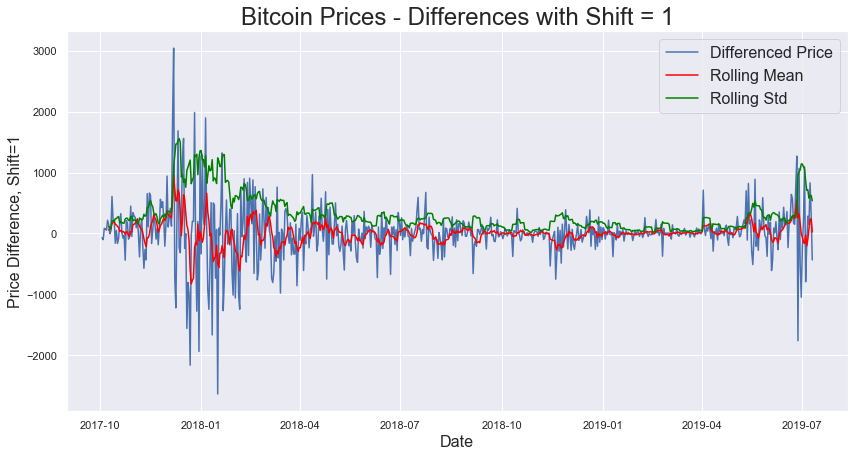

In [116]:
# Plot
df_m_diff1 = df_m.diff(periods=1)
df_m_diff1 = df_m_diff1[1:]

rol_mean1 = df_m_diff1['Bitcoin'].rolling(window=7).mean()
rol_std1 = df_m_diff1['Bitcoin'].rolling(window=7).std()

plt.figure(figsize=(14,7))
plt.plot(df_m_diff1['Bitcoin'], label = 'Differenced Price')
mean = plt.plot(rol_mean1, color='red',label='Rolling Mean')
std = plt.plot(rol_std1, color='green',label='Rolling Std')
plt.title("Bitcoin Prices - Differences with Shift = 1", fontsize=24)
plt.legend(loc='best', fontsize=16)

plt.xlabel("Date", fontsize=16)
plt.ylabel("Price Difference, Shift=1", fontsize=16)
plt.show()

In [122]:
res = adfuller(df_m_diff1['Bitcoin'],autolag='AIC')
print("Dickey-Fuller Test Results")
print("")
print(f"ADF STATS: {res[0]}")
print(f"p-value: {res[1]}")
print(f"Lags Used: {res[2]}")
print("")

print('Critical Values:')

for i,j in res[4].items():
    print(f"\t {i}: {j}")

Dickey-Fuller Test Results

ADF STATS: -4.542786151623504
p-value: 0.00016444710166514103
Lags Used: 19

Critical Values:
	 1%: -3.4408393249134326
	 5%: -2.86616806030903
	 10%: -2.569234676071002


### Yes, with a differencing step = 1, we have transformed our data to become stationary, with a number of lags used = 19.

### Lets turn to Autoregression and Moving Averages. Lets start with viewing our autocorrelation plots.

In [123]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 864x504 with 0 Axes>

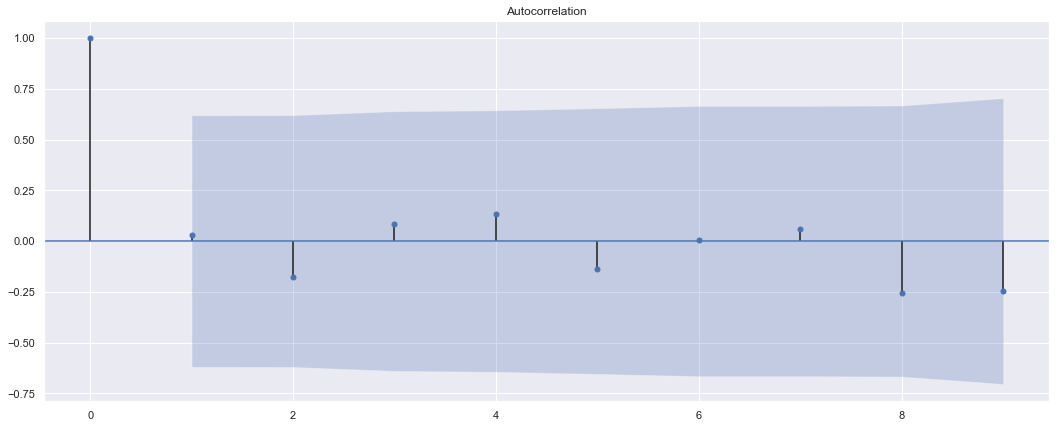

In [125]:
#View differenced data

plt.figure(figsize=(12,7))
plot_acf(df_m_diff1['Bitcoin'][:10])
plt.show()

<Figure size 576x288 with 0 Axes>

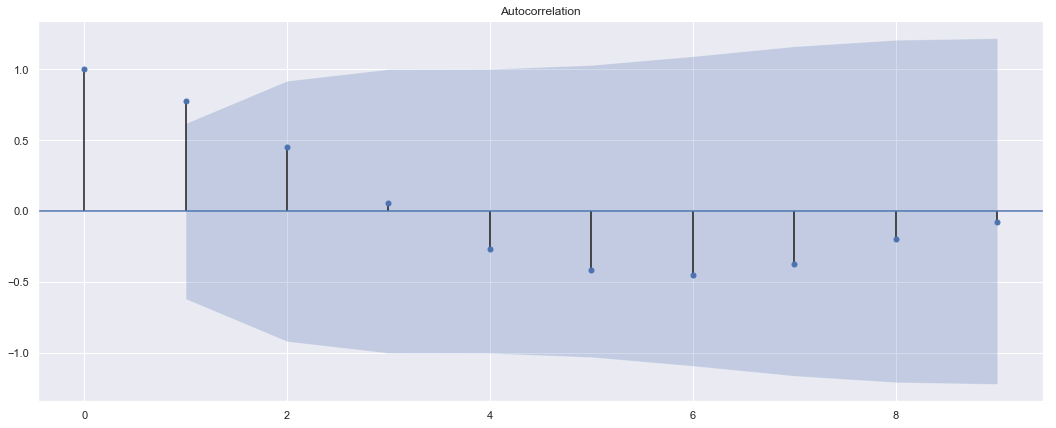

In [126]:
#Non-differenced Data
plt.figure(figsize=(8,4))
plot_acf(df_m['Bitcoin'][:10])
plt.show()

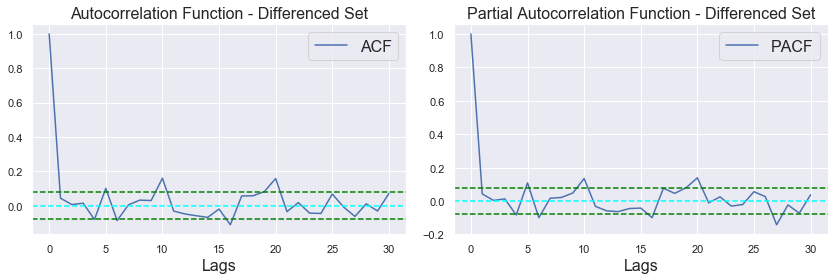

In [129]:
# View for the differenced set
lag_acf = acf(df_m_diff1['Bitcoin'], nlags=30)
lag_pacf = pacf(df_m_diff1['Bitcoin'], nlags=30, method='ols')

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lag_acf, label='ACF')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(df_m_diff1)), linestyle='--', color='green')
plt.axhline(y=1.96/np.sqrt(len(df_m_diff1)), linestyle='--', color='green')
plt.legend(loc='best', fontsize=16)
plt.title("Autocorrelation Function - Differenced Set",fontsize=16)
plt.xlabel("Lags", fontsize=16)

plt.subplot(122)
plt.plot(lag_pacf, label='PACF')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(df_m_diff1)), linestyle='--', color='green')
plt.axhline(y=1.96/np.sqrt(len(df_m_diff1)), linestyle='--', color='green')
plt.legend(loc='best', fontsize=16)
plt.title("Partial Autocorrelation Function - Differenced Set", fontsize=16)
plt.xlabel("Lags", fontsize=16)
plt.tight_layout()

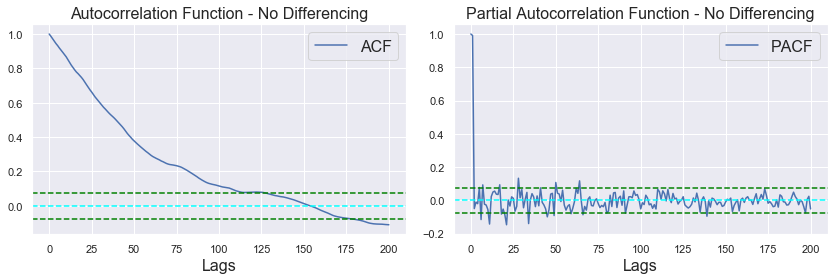

In [130]:
lag_acf = acf(df_m['Bitcoin'], nlags=200)
lag_pacf = pacf(df_m['Bitcoin'], nlags=200, method='ols')

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lag_acf, label='ACF')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(df_m)), linestyle='--', color='green')
plt.axhline(y=1.96/np.sqrt(len(df_m)), linestyle='--', color='green')
plt.legend(loc='best', fontsize=16)
plt.title("Autocorrelation Function - No Differencing",fontsize=16)
plt.xlabel("Lags", fontsize=16)

plt.subplot(122)
plt.plot(lag_pacf, label='PACF')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(df_m)), linestyle='--', color='green')
plt.axhline(y=1.96/np.sqrt(len(df_m)), linestyle='--', color='green')
plt.legend(loc='best', fontsize=16)
plt.title("Partial Autocorrelation Function - No Differencing", fontsize=16)
plt.xlabel("Lags", fontsize=16)
plt.tight_layout()

### With differencing our data, we can use much less lags for implementing the AR and MA portions (p, q) of our time series model.

In [131]:
# Divide data into test and train sets. The test set will comprise of the final 3 months of our set - April, May, June,
# and beginning of July, 2019.
train = df_m.loc[:'2019-04-09']
test = df_m.loc['2019-04-09':]

In [132]:
# Model 1 - use p = q = 1 based on the autocorrelation functions above, and d = 1 for the differencing (I portion)

mod1 = sms.tsa.statespace.SARIMAX(train['Bitcoin'],order=(1, 1, 1), seasonal_order=(0, 1, 0, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=False, freq='D')

results1 = mod1.fit()
print(results1.aic)
print(results1.summary())


C:\Users\Tom N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


8595.876109731842
                                 Statespace Model Results                                
Dep. Variable:                           Bitcoin   No. Observations:                  555
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 7)   Log Likelihood               -4294.938
Date:                           Tue, 16 Jul 2019   AIC                           8595.876
Time:                                   12:15:01   BIC                           8608.789
Sample:                               10-02-2017   HQIC                          8600.924
                                    - 04-09-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4597      0.156     -2.947      0.003      -0.765      -0.154
ma.L1          0.5677    

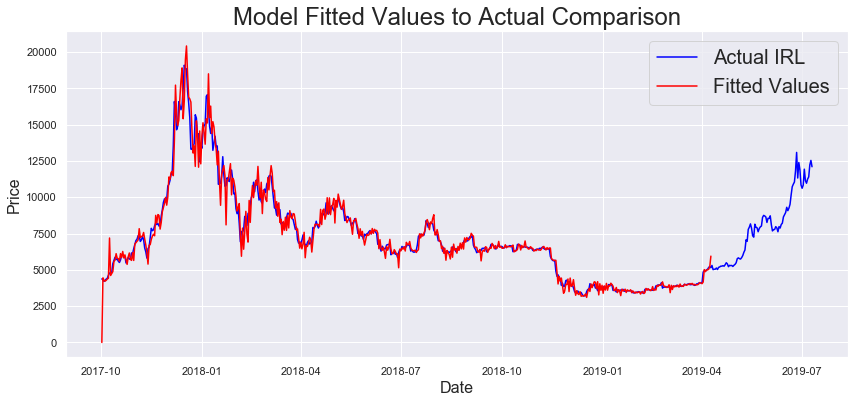

In [135]:
plt.figure(figsize=(14,6))
plt.plot(df_m['Bitcoin'], color='blue', label='Actual IRL')
plt.plot(results1.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='best', fontsize=20)
plt.title("Model Fitted Values to Actual Comparison", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Price", fontsize=16)

plt.show()

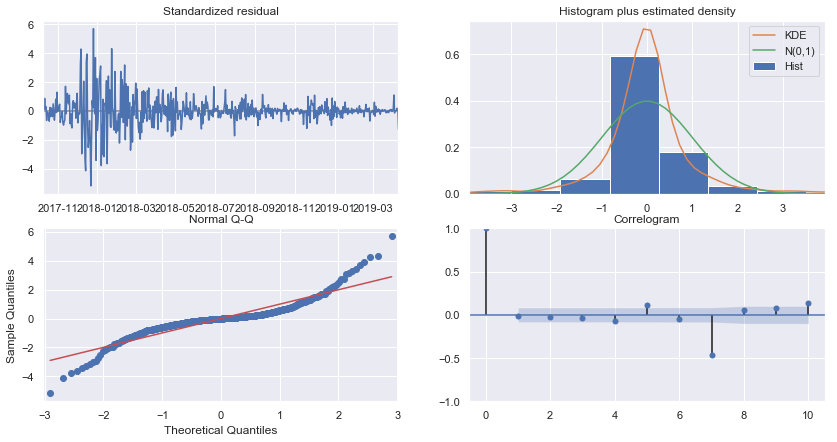

In [136]:
results1.plot_diagnostics(figsize=(14, 7))
plt.show()

In [138]:
# Confirm that our errors (residuals) are normally distributed.

from scipy.stats import kstest
kstest(results1.resid,'norm')

KstestResult(statistic=0.5027023180235647, pvalue=2.5622308410817012e-130)

In [148]:
pred1 = results1.get_prediction(start=pd.to_datetime('2019-04-09'), end=pd.to_datetime('2019-08-01'), dynamic=False)

In [149]:
pred_mean1 = pred1.predicted_mean
pred_mean1 = pd.DataFrame(pred_mean1, columns=['Mean'])
pred_ci1 = pred1.conf_int()

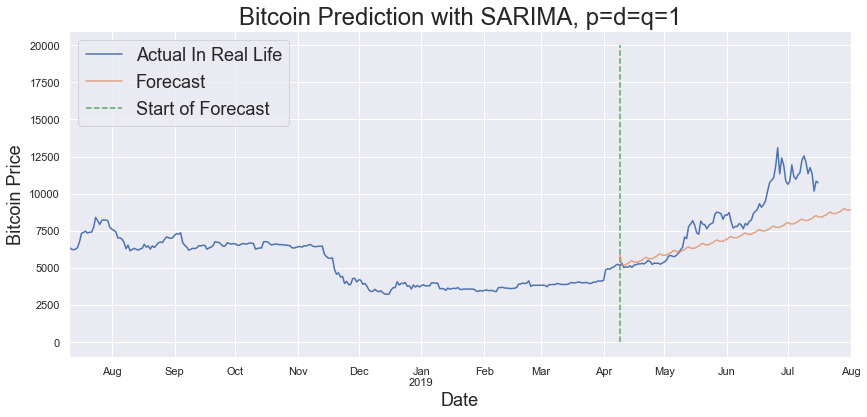

In [151]:
ax = df_BTC['Close'].loc['2018-07-11':].plot(label='Actual In Real Life')

pred_mean1['Mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 6))

ax.vlines('2019-04-09', 0, 20000, linestyle='--', color='g', label='Start of Forecast')
ax.set_title('Bitcoin Prediction with SARIMA, p=d=q=1', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Bitcoin Price', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

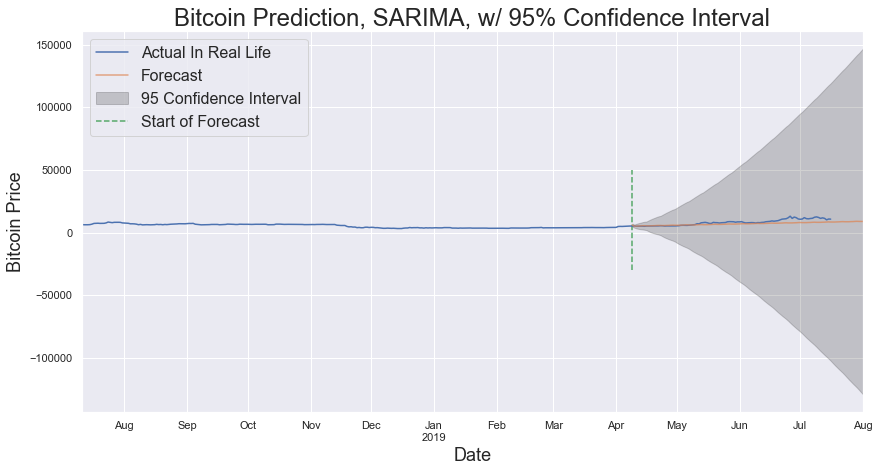

In [153]:
ax = df_BTC['Close'].loc['2018-07-11':].plot(label='Actual In Real Life')


pred_mean1['Mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.2, label='95 Confidence Interval')
ax.vlines('2019-04-09', -30000, 50000, linestyle='--', color='g', label='Start of Forecast')
ax.set_title('Bitcoin Prediction, SARIMA, w/ 95% Confidence Interval', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Bitcoin Price', fontsize=18)
plt.legend(loc='upper left', fontsize=16)
plt.show()

## Observations:

1. Our prediction accurately captures that the Bitcoin price is trending upwards, however the slope is a bit flatter than reality. We undershoot the July price by a couple thousand dollars.

2. Our confidence interval range in the second plot is enormous, which is to be expected for something as volatile as Cryptocurrency. Right away we can tell that a model such as this should not be trusted for long term predictions.

Lets try a second model using a p = 19, the number of lags used in the earlier Dickey-Fuller test. The MA value (q) is set = 2. If we use q=1 the AIC score is slightly larger (~8349).

In [181]:
mod2 = sms.tsa.statespace.SARIMAX(train['Bitcoin'],order=(19, 1, 2), seasonal_order=(0, 1, 0, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=False, freq='D')

results2 = mod2.fit()
print(results2.aic)
print(results2.summary())


C:\Users\Tom N\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8342.598823299793
                                 Statespace Model Results                                 
Dep. Variable:                            Bitcoin   No. Observations:                  555
Model:             SARIMAX(19, 1, 2)x(0, 1, 0, 7)   Log Likelihood               -4149.299
Date:                            Tue, 16 Jul 2019   AIC                           8342.599
Time:                                    12:51:12   BIC                           8437.297
Sample:                                10-02-2017   HQIC                          8379.614
                                     - 04-09-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3057      0.147      2.074      0.038       0.017       0.595
ar.L2         -0.

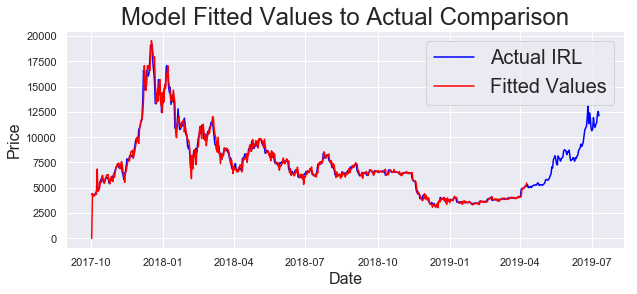

In [182]:
plt.figure(figsize=(10,4))
plt.plot(df_m['Bitcoin'], color='blue', label='Actual IRL')
plt.plot(results2.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='best', fontsize=20)
plt.title("Model Fitted Values to Actual Comparison", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Price", fontsize=16)

plt.show()

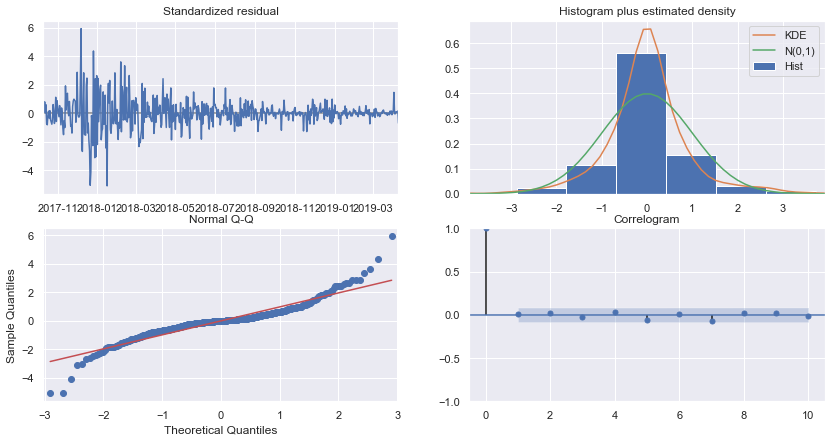

In [183]:
results2.plot_diagnostics(figsize=(14, 7))
plt.show()

In [184]:
# Confirm that our errors (residuals) are normally distributed.
kstest(results2.resid,'norm')

KstestResult(statistic=0.5008135552875533, pvalue=2.830404429868126e-129)

In [185]:
# Get prediction to compare with test set.

pred2 = results2.get_prediction(start=pd.to_datetime('2019-04-09'), end=pd.to_datetime('2019-08-01'), dynamic=False)

pred_mean2 = pred2.predicted_mean
pred_mean2 = pd.DataFrame(pred_mean2, columns=['Mean'])
pred_ci2 = pred2.conf_int()

C:\Users\Tom N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


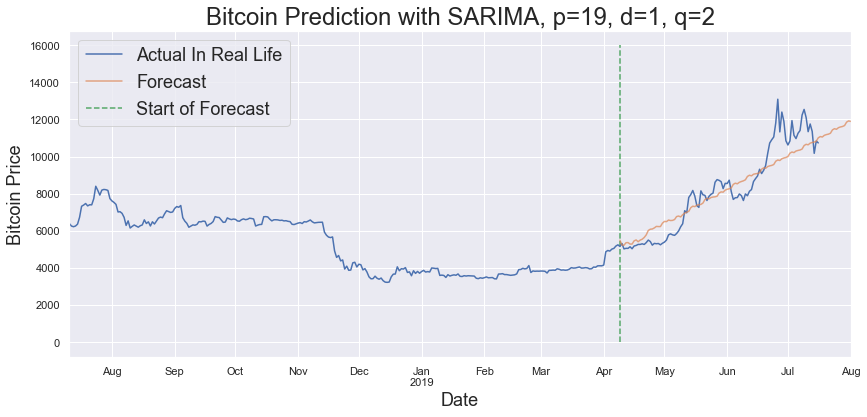

In [186]:
ax = df_BTC['Close'].loc['2018-07-11':].plot(label='Actual In Real Life')

pred_mean2['Mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 6))

ax.vlines('2019-04-09', 0, 16000, linestyle='--', color='g', label='Start of Forecast')
ax.set_title('Bitcoin Prediction with SARIMA, p=19, d=1, q=2', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Bitcoin Price', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

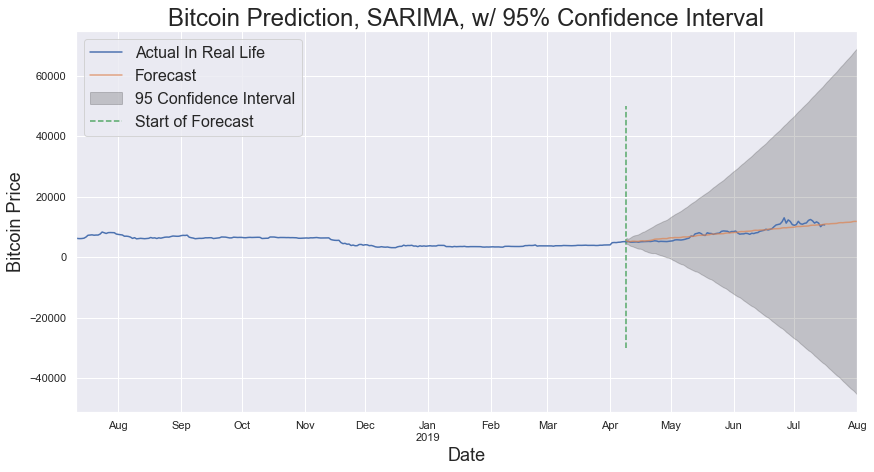

In [187]:
ax = df_BTC['Close'].loc['2018-07-11':].plot(label='Actual In Real Life')

pred_mean2['Mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2, label='95 Confidence Interval')
ax.vlines('2019-04-09', -30000, 50000, linestyle='--', color='g', label='Start of Forecast')
ax.set_title('Bitcoin Prediction, SARIMA, w/ 95% Confidence Interval', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Bitcoin Price', fontsize=18)
plt.legend(loc='upper left', fontsize=16)
plt.show()

Our prediction improves with the inclusion of more lags. If we really would like to fine-tune the model, we would attempt many combinations of p,d,q to determine the combination that leads to the lowest AIC value.

### Next step = Introduce Exogenuous Variable "NASDAQ"

Lets see if introducing the NASDAQ index value over the same time frame helps us build a stronger model. Now, from the above plots

In [188]:
mod3 = sms.tsa.statespace.SARIMAX(train['Bitcoin'],order=(19, 1, 2), seasonal_order=(0, 1, 0, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=False,
                                exog = train['Nasdaq'], freq='D')

results3 = mod3.fit()
print(results3.summary())

C:\Users\Tom N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Tom N\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                            Bitcoin   No. Observations:                  555
Model:             SARIMAX(19, 1, 2)x(0, 1, 0, 7)   Log Likelihood               -4147.672
Date:                            Tue, 16 Jul 2019   AIC                           8341.344
Time:                                    12:54:38   BIC                           8440.347
Sample:                                10-02-2017   HQIC                          8380.042
                                     - 04-09-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Nasdaq         0.2307      0.315      0.732      0.464      -0.387       0.849
ar.L1         -0.3198      0.153   

In [189]:
kstest(results3.resid,'norm')

KstestResult(statistic=0.5104247318824869, pvalue=1.2279562105257672e-134)

In [194]:
exog=pd.DataFrame(test['Nasdaq'].iloc[:-1])
exog.shape

(92, 1)

In [195]:
pred3 = results3.get_prediction(start=pd.to_datetime('2019-04-09'), end=pd.to_datetime('2019-07-10'), dynamic=False, exog=pd.DataFrame(test['Nasdaq'].iloc[:-1]))

In [198]:
pred_mean3 = pred3.predicted_mean
pred_mean3 = pd.DataFrame(pred_mean2, columns=['Mean'])

In [199]:
pred_ci3 = pred3.conf_int()

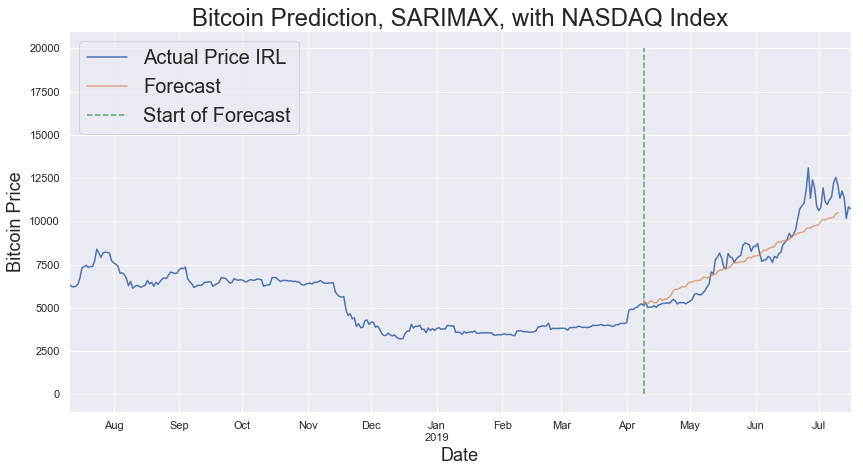

In [201]:
ax = df_BTC['Close'].loc['2018-07-11':].plot(label='Actual Price IRL')


pred_mean3['Mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.vlines('2019-04-09', 0, 20000, linestyle='--', color='g', label='Start of Forecast')
ax.set_title('Bitcoin Prediction, SARIMAX, with NASDAQ Index', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Bitcoin Price', fontsize=18)
plt.legend(loc='upper left', fontsize=20)
plt.show()

We see a minor improvement in the AIC value, but as expected when viewing the plot of Bitcoin price and the NASDAQ index, there is no real correlation. Cryptocurrency appears to be in a world of its own.



Truth is while we may be able to get a short-term feel for the direction of Bitcoin (or other similar cryptocurrencies, SARIMAX may not be an appropriate approach to forecast something this volatile. It is difficult to capture the emotional "fan fever" behind cryptocurrency. SARIMAX would be more fitting for something more predictable over time, with a clear seasonality and trend.

